<a href="https://colab.research.google.com/github/vicmcl/malaria-detection/blob/main/notebook_malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Detection**

## **Mount the Drive**

In [ ]:
from pathlib import Path
from google.colab import drive

content_path = Path('/').absolute() / 'content'
drive_path = content_path / 'drive'
drive.mount(str(drive_path))

Mounted at /content/drive


## **Import the dataset from Kaggle**

In [ ]:
DATASET = "iarunava/cell-images-for-detecting-malaria"

In [ ]:
! mkdir ~/.kaggle
! cp "{drive_path / 'MyDrive' / 'API' / 'kaggle.json'}" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download "{DATASET}"

100% 673M/675M [00:06<00:00, 102MB/s] 
100% 675M/675M [00:06<00:00, 110MB/s]


## **Pre-processing**

In [ ]:
# Importing libraries required to load the data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from zipfile import ZipFile

sns.set()

In [ ]:
# Unzip the archive
with content_path / str(DATASET.split("/")[1] + ".zip") as zip_path:
    ZipFile(zip_path, 'r').extractall()

In [ ]:
# Root path for the training data
root = content_path / "cell_images"

In [ ]:
# Remove nested copy of the directory
! rm -rf cell_images/cell_images

#### **Split the data in training and test sets**

In [ ]:
# Number of uninfected and parasitized cells in the test dataset
TEST_SET_SIZE = 1300

# Initialize an array for training/test images and labels
x_train, y_train = [], []

# Add uninfected cells to the training and test datasets
uninfected_path = root / "Uninfected"

for filepath in uninfected_path.iterdir():
    if filepath.name.endswith("png"):
        y_train.append(0)
        x_train.append(Image.open(filepath).resize((64, 64)))

# The test set takes the last 1300 images of the uninfected cells
x_test = x_train[-TEST_SET_SIZE:]
y_test = y_train[-TEST_SET_SIZE:]

# Update the training set
x_train = x_train[:-TEST_SET_SIZE]
y_train = y_train[:-TEST_SET_SIZE]

# Add uninfected cells to the training and test datasets
uninfected_path = root / "Parasitized"

for filepath in uninfected_path.iterdir():
    if filepath.name.endswith("png"):
        y_train.append(1)
        x_train.append(Image.open(filepath).resize((64, 64)))

# The test set takes the last 1300 images of the parasitized cells
x_test += x_train[-TEST_SET_SIZE:]
y_test += y_train[-TEST_SET_SIZE:]

# Update the training set
x_train = x_train[:-TEST_SET_SIZE]
y_train = y_train[:-TEST_SET_SIZE]

# Convert the images to arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

<ipython-input-10-ac016e4742d8>:40: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x_train = np.array(x_train)
<ipython-input-10-ac016e4742d8>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array(x_train)
<ipython-input-10-ac016e4742d8>:42: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (

#### **Normalize the images**

In [ ]:
x_train = np.array([np.array(x) / 255 for x in x_train]).astype("float32")
x_test = np.array([np.array(x) / 255 for x in x_test]).astype("float32")

#### **Countplots**

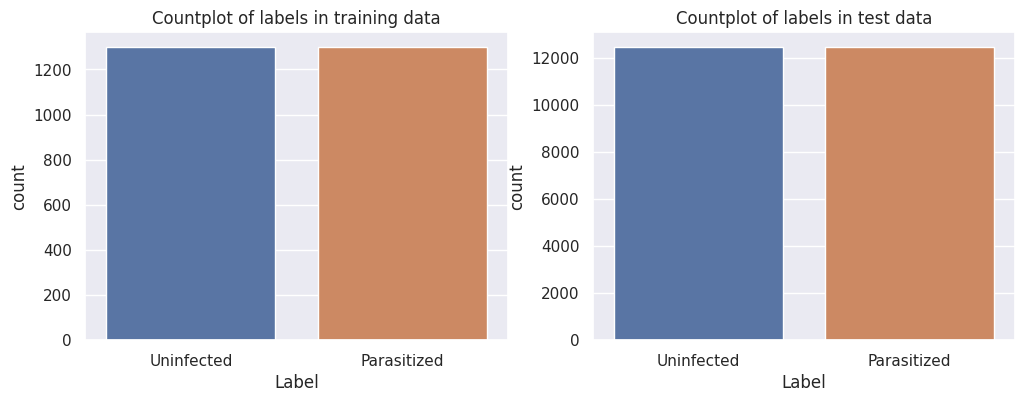

In [ ]:
labels = ["Uninfected", "Parasitized"]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Create two dataframe to associate each image with its label
df_train = pd.DataFrame(zip(x_train, y_train),
                        columns = ["Image", "Label"])

df_test = pd.DataFrame(zip(x_test, y_test),
                       columns = ["Image", "Label"])

pos = 0
for df in [df_test, df_train]:
    for i in labels:
        df["Label"].replace(labels.index(i), i, inplace=True)

    # Plot the countplot of labels in df_train
    sns.countplot(
        data = df,
        x = "Label",
        ax = axes[pos]
    )

    title = "training" if pos == 0 else "test"
    axes[pos].set_title(f"Countplot of labels in {title} data")
    pos += 1

plt.show()

- The training dataset is well balanced with a 50/50 split between the images of parasitized and uninfected cells. Therefore, the models should be able to train on a similar number of images of parasitized and uninfected cells, which is likely to improve the results against new data.

#### **Visualization**

In [ ]:
def plot_images(images, labels, n):
    # Set the figure size
    fig = plt.figure(figsize = (n * 2, 2))

    # Generate a list of random indexes
    random_index = [random.randint(0, len(images) + 1) for _ in range(n)]

    # From the random indexes, plot a row of n images with their associated label
    for i in range(n):
        label = "Uninfected" if labels[random_index[i]] == 0 else "Parasitized"
        ax = fig.add_subplot(int("1" + str(n) + str(i)) + 1)
        plt.imshow(images[random_index[i]])
        ax.set_xlabel(label)

    fig.tight_layout()
    plt.show()

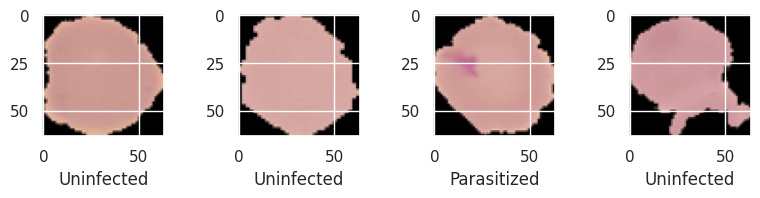

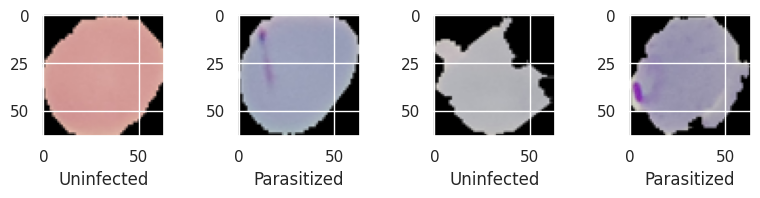

In [ ]:
for _ in range(2):
    plot_images(x_train, y_train, 4)

## **CNN**

In [ ]:
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.random import set_seed

from tensorflow.keras import backend, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    LeakyReLU,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
)


####<b>One Hot Encoding the train and test labels</b>

In [ ]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

#### **Callbacks**

In [ ]:
def checkpoint(fname):

    callbacks = [
        EarlyStopping(patience=20),   # Stop the training after 20 iterations without improvement
        ModelCheckpoint(              # Save the weights giving the best results in a file
            filepath = str(drive_path / "MyDrive" / fname),
            monitor = "val_loss",
            save_best_only = True,
        )
    ]

    return callbacks

#### **Plotting the training and validation loss**

In [ ]:
def plot_training(hist):
    # Loss on the training data
    plt.plot(range(1, len(hist.epoch) + 1), hist.history['loss'])

    # Loss on the validation data
    plt.plot(range(1, len(hist.epoch) + 1), hist.history['val_loss'])

    # Axis parameters
    plt.ylim(0, 1)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

#### **Evaluating the model on test data**

In [ ]:
def prediction(model, x_test, y_test):
    # Apply the model to the test dataset to get new predictions
    y_pred = model.predict(x_test)
    # Get the index of the 1 in the predicted labels and true labels
    y_pred_arg = np.argmax(y_pred, axis=1)
    y_test_arg = np.argmax(y_test_encoded, axis=1)

    return y_test_arg, y_pred_arg

#### **Plotting the confusion matrix**

In [ ]:
def report_and_matrix(test, pred):
    # Print the classification report
    report = classification_report(test, pred)

    print(report)
    print("----------------------------------------------------------------------")
    print()

    # Plot the confusion matrix
    cm = tf.math.confusion_matrix(test, pred)
    ax = sns.heatmap(
            cm,
            annot = True,
            linewidths = 0.4,
            fmt = "d",
            square = True,
         )

    ax.set(
        xlabel = 'Predicted Labels',
        ylabel = 'True Labels',
    )

    plt.show()

    # Return the report and the confusion matrix in a dictionary
    return {"report": report, "matrix": cm}

In [ ]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

#### **Building the model**

In [ ]:
def model_1():
    # Sequential model
    model = Sequential()

    # First convolution layer with 32 filters
    model.add(
        Conv2D(
            filters = 32,
            kernel_size = 2,
            padding = "same",
            activation = "relu",
            input_shape = (64, 64, 3),
        )
    )

    model.add(MaxPooling2D(pool_size = 2))
    model.add(Dropout(rate = 0.3))

    # Second convolution layer with 64 filters
    model.add(
        Conv2D(
            filters = 64,
            kernel_size = 2,
            padding = "same",
            activation = "relu",
        )
    )

    model.add(MaxPooling2D(pool_size = 2))
    model.add(Dropout(rate = 0.3))

    # Third convolution layer with 128 filters
    model.add(
        Conv2D(
            filters = 128,
            kernel_size = 2,
            padding="same",
            activation="relu",
        )
    )

    model.add(MaxPooling2D(pool_size = 2))
    model.add(Dropout(rate = 0.3))

    # FFNN
    model.add(Flatten())
    model.add(
        Dense(
            128,
            activation = 'relu',
        )
    )

    model.add(Dropout(rate=0.5))
    model.add(
        Dense(
            2,
            activation = 'softmax',
        )
    )

    # Compile the model
    model.compile(
        loss="binary_crossentropy",
        optimizer = Adam(learning_rate = 0.0005),
        metrics = ["accuracy"]
    )

    return model

In [ ]:
m_1 = model_1()

m_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

#### **Fit and train the model**

In [ ]:
history_1 = m_1.fit(
                x_train,
                y_train_encoded,
                epochs=100,
                callbacks=checkpoint("weights_model_1.hdf5"),
                validation_split=0.2,
                batch_size=32,
                verbose=1
            )

Epoch 1/100
624/624 [==============================] - 20s 11ms/step - loss: 0.5366 - accuracy: 0.7353 - val_loss: 0.4216 - val_accuracy: 0.8850
Epoch 2/100
  8/624 [..............................] - ETA: 5s - loss: 0.2781 - accuracy: 0.9102

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


624/624 [==============================] - 6s 9ms/step - loss: 0.2016 - accuracy: 0.9313 - val_loss: 0.2438 - val_accuracy: 0.9165
Epoch 3/100
624/624 [==============================] - 6s 9ms/step - loss: 0.1734 - accuracy: 0.9449 - val_loss: 0.2335 - val_accuracy: 0.9173
Epoch 4/100
624/624 [==============================] - 6s 9ms/step - loss: 0.1605 - accuracy: 0.9506 - val_loss: 0.1894 - val_accuracy: 0.9291
Epoch 5/100
624/624 [==============================] - 6s 9ms/step - loss: 0.1554 - accuracy: 0.9540 - val_loss: 0.1527 - val_accuracy: 0.9423
Epoch 6/100
624/624 [==============================] - 6s 9ms/step - loss: 0.1504 - accuracy: 0.9540 - val_loss: 0.1477 - val_accuracy: 0.9437
Epoch 7/100
624/624 [==============================] - 6s 9ms/step - loss: 0.1435 - accuracy: 0.9564 - val_loss: 0.1711 - val_accuracy: 0.9399
Epoch 8/100
624/624 [==============================] - 6s 9ms/step - loss: 0.1385 - accuracy: 0.9574 - val_loss: 0.1666 - val_accuracy: 0.9357
Epoch 9/100

#### **Plotting the train and the validation curves**

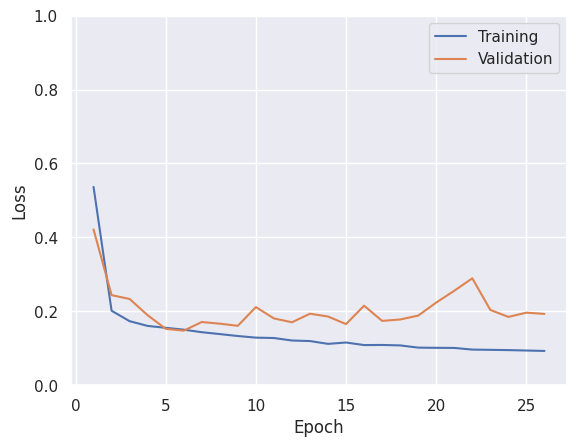

In [ ]:
plot_training(history_1)

The model overfits the training data, as the loss does not decrease on the validation set.

#### **Evaluating the model**

In [ ]:
test_1, pred_1 = prediction(m_1, x_test, y_test_encoded)

82/82 [==============================] - 0s 3ms/step


#### **Plotting the confusion matrix**

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1300
           1       0.98      0.95      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600

----------------------------------------------------------------------



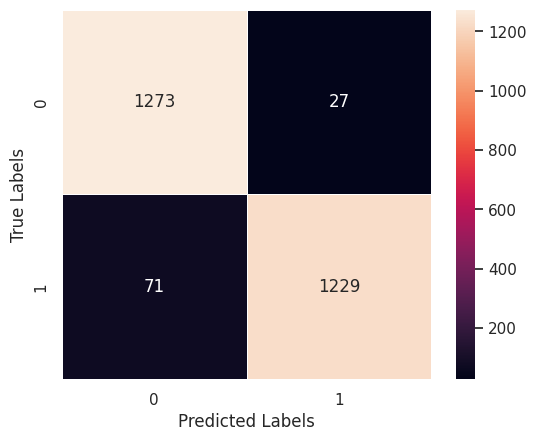

In [ ]:
stat_1 = report_and_matrix(test_1, pred_1)

- Label 0 = uninfected, label 1 = parasitized
- This model reaches a 96% accuracy on the test data. It misclassified 98 cells, including 71 false negatives. It is critical to minimize this number which represents the parasitized cells predicted as uninfected, in the case of a diagnosis.

## **Data Augmentation**

In [ ]:
from sklearn.model_selection import train_test_split

# Split the training data into training images/labels and validation images/labels with a ratio of 80%/20%
x_train_aug, x_val_aug, y_train_aug, y_val_aug = train_test_split(x_train,
                                                                  y_train_encoded,
                                                                  test_size=0.2,
                                                                  random_state=42)

# Parameters to generate new images
generator = ImageDataGenerator(
                horizontal_flip=True, # Can flip the image upside down
                zoom_range=0.5,       # Can zoom in the image up to 2x
                rotation_range=30     # Can rotate the image up to 30°
            )

# Create an iterator with new images
augmented_data = generator.flow(
                    x=x_train_aug,
                    y=y_train_aug,
                    batch_size=32,
                    seed=42,
                    shuffle=True
                 )

In [ ]:
m_2 = model_1()

In [ ]:
history_2 = m_2.fit(
                augmented_data,
                epochs=100,
                callbacks=checkpoint("MyDrive/weights_model_5.hdf5"),
                validation_data=(x_val_aug, y_val_aug),
                verbose=1
            )

Epoch 1/100
624/624 [==============================] - 28s 41ms/step - loss: 0.6360 - accuracy: 0.6434 - val_loss: 0.4936 - val_accuracy: 0.8780
Epoch 2/100
  1/624 [..............................] - ETA: 37s - loss: 0.6695 - accuracy: 0.7500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


624/624 [==============================] - 26s 41ms/step - loss: 0.3389 - accuracy: 0.8800 - val_loss: 0.1889 - val_accuracy: 0.9321
Epoch 3/100
624/624 [==============================] - 26s 41ms/step - loss: 0.2773 - accuracy: 0.8992 - val_loss: 0.1837 - val_accuracy: 0.9309
Epoch 4/100
624/624 [==============================] - 26s 41ms/step - loss: 0.2654 - accuracy: 0.9078 - val_loss: 0.1704 - val_accuracy: 0.9447
Epoch 5/100
624/624 [==============================] - 25s 41ms/step - loss: 0.2518 - accuracy: 0.9097 - val_loss: 0.1652 - val_accuracy: 0.9481
Epoch 6/100
624/624 [==============================] - 25s 40ms/step - loss: 0.2454 - accuracy: 0.9141 - val_loss: 0.1769 - val_accuracy: 0.9497
Epoch 7/100
624/624 [==============================] - 25s 41ms/step - loss: 0.2432 - accuracy: 0.9179 - val_loss: 0.1644 - val_accuracy: 0.9527
Epoch 8/100
624/624 [==============================] - 26s 41ms/step - loss: 0.2391 - accuracy: 0.9180 - val_loss: 0.1619 - val_accuracy: 0.95

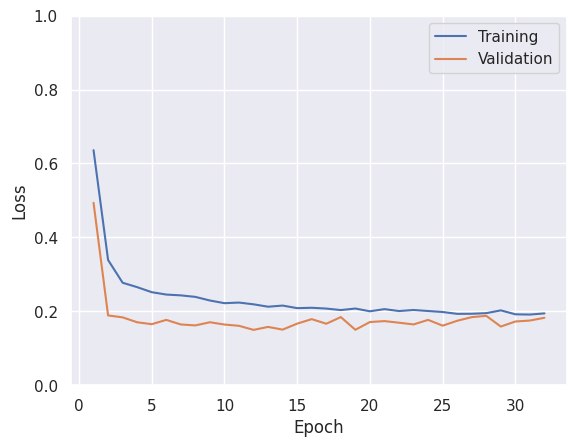

In [ ]:
plot_training(history_2)

In [ ]:
test_2, pred_2 = prediction(m_2, x_test, y_test_encoded)

82/82 [==============================] - 0s 2ms/step


              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1300
           1       0.98      0.94      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600

----------------------------------------------------------------------



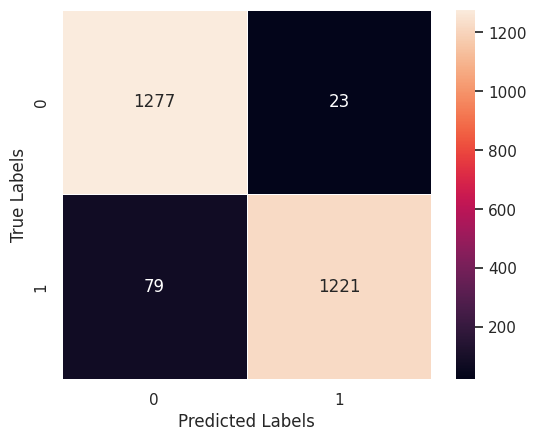

In [ ]:
stat_5 = report_and_matrix(test_2, pred_2)

- The accuracy is again rounded to 96%, but with 102 misclassification this time, including only 79 false negatives.
- Data augmentation provides a tool to make the training more robust with more general features learned via the distorsion of the images. It helps reduce overfitting, as seen in the loss plot: the validation loss remains inferior to the training loss at all epoch.
